In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
np.random.seed(123)
rng = np.random.default_rng()

product = True
proportion = 0.5
n_ground_truth = 100000
weight = 1 #lower weight pushes y_probs towards 0.5
cov = np.array(
    [[1,0,0,0,0],
    [0,1,0.5,0,0],
    [0,0.5,1,0,0],
    [0,0,0,1,-0.5],
    [0,0,0,-0.5,1]])
x = rng.multivariate_normal(mean=np.zeros(5), cov=cov, size=(n_ground_truth,))
g = (rng.uniform(size = (n_ground_truth,)) > proportion).astype(np.int8)
xg = x.copy()
xg[:,1] = xg[:,1] + 0.5*g
xg[:,4] = xg[:,4] - 0.5*g

if product:
    x14 = (xg[:,1] * xg[:,4]).reshape((len(xg),1))
    x23 = (xg[:,2] * xg[:,3]).reshape((len(xg),1))
    coef = weight*np.array([-2, 3, -4, 3, -1, 2, 1])
    xg_input = np.hstack((xg, x14, x23))

else:
    coef = weight*np.array([-2, 3, -4, 3, -1])
    xg_input = xg
y = (1/(1+np.exp(-xg_input@coef)) > 0.5).astype(np.int8)
y_probs = 1/(1+np.exp(-xg_input@coef))
threshold_truth = np.mean(y[g==1]) - np.mean(y[g==0])
prob_truth = np.mean(y_probs[g==1]) - np.mean(y_probs[g==0])
print(threshold_truth)
print(prob_truth)

0.10924658827070632
0.10221019738395964


In [94]:
# investigating differences between true probs and estimated probs
model = LogisticRegression().fit(xg, y)
phi0 = -1/np.mean(g==0) * model.predict(xg[np.where(g==0)[0],:])
phi1 = 1/np.mean(g==1) * model.predict(xg[np.where(g==1)[0],:])
phi = np.hstack([phi0, phi1])
est = np.mean(phi)
eif = phi - np.mean(phi)

In [ ]:
def sim1(
    n,
    metric,
    rng = None):
    
    n = n // 2
    if rng is None:
        rng = np.random.default_rng()

    cov = np.array(
    [[1,0,0,0,0],
    [0,1,0.5,0,0],
    [0,0.5,1,0,0],
    [0,0,0,1,-0.5],
    [0,0,0,-0.5,1]])
    x = rng.multivariate_normal(mean=np.zeros(5), cov=cov, size=(2*n,))
    g = (rng.uniform(size = (2*n,)) > proportion).astype(np.int8)
    xg = x
    xg[:,1] = xg[:,1] + 0.5*g
    xg[:,4] = xg[:,4] - 0.5*g

    x14 = (xg[:,1] * xg[:,4]).reshape((len(xg),1))
    x23 = (xg[:,2] * xg[:,3]).reshape((len(xg),1))
    coef = np.array([-2, 3, -4, 3, -1, 2, 1])
    xg_input = np.hstack((xg, x14, x23))

    y = (1/(1+np.exp(-xg_input@coef)) > 0.5).astype(np.int8)

    xgtrain = xg[:n,:]
    gtrain = g[:n]
    ytrain = y[:n]
    xgtest = xg[n:,:]
    gtest = g[n:]
    ytest = y[n:]

    res = metric(
        xtr = xgtrain,
        xte = xgtest,
        ytr = ytrain,
        yte = ytest,
        gtr = gtest,
        gtr = gtrain,
        outcome = LogisticRegression(solver='liblinear'),
        propensity = LogisticRegression(solver='liblinear')
    )
    return res

In [25]:
def parity_sim(
    n,
    proportion = 0.5,
    parity='threshold',
    product=True):
    
    rng = np.random.default_rng()

    cov = np.array(
    [[1,0,0,0,0],
    [0,1,0.5,0,0],
    [0,0.5,1,0,0],
    [0,0,0,1,-0.5],
    [0,0,0,-0.5,1]])
    x = rng.multivariate_normal(mean=np.zeros(5), cov=cov, size=(2*n,))
    g = (rng.uniform(size = (2*n,)) > proportion).astype(np.int8)
    xg = x
    xg[:,1] = xg[:,1] + 0.5*g
    xg[:,4] = xg[:,4] - 0.5*g

    if product:
        x14 = (xg[:,1] * xg[:,4]).reshape((len(xg),1))
        x23 = (xg[:,2] * xg[:,3]).reshape((len(xg),1))
        coef = np.array([-2, 3, -4, 3, -1, 2, 1])
        xg_input = np.hstack((xg, x14, x23))

    else:
        coef = np.array([-2, 3, -4, 3, -1])
        xg_input = xg
    
    y = (1/(1+np.exp(-xg_input@coef)) > 0.5).astype(np.int8)

    xgtrain = xg[:n,:]
    gtrain = g[:n]
    ytrain = y[:n]
    xgtest = xg[n:,:]
    gtest = g[n:]
    ytest = y[n:]

    model = LogisticRegression().fit(xgtrain,ytrain)

    if parity == 'threshold':
        preds = model.predict(xgtest)
        phi0 = -1/np.mean(gtest==0) * preds[np.where(gtest==0)[0]]
        phi1 = 1/np.mean(gtest==1) * preds[np.where(gtest==1)[0]]
        phi = np.hstack([phi0, phi1])
        est = np.mean(phi)
        eif = phi - np.mean(phi)
        var = np.var(eif)/n
        naive_est = np.mean(preds[np.where(gtest==1)[0]]) - np.mean(preds[np.where(gtest==0)[0]])
        naive_var = (np.var(preds[np.where(gtest==1)[0]]) + np.var(preds[np.where(gtest==0)[0]]))/n

    if parity == 'prob':
        propensity = LogisticRegression().fit(xgtrain,gtrain)
        m_probs = propensity.predict_proba(xgtest)
        f_probs = model.predict_proba(xgtest)[:,1]
        phi0 = -1/(np.mean(gtest==0)) * (m_probs[:,0]*((ytest==1) -f_probs) + (gtest==0)*f_probs)
        phi1 = 1/(np.mean(gtest==1)) * (m_probs[:,1]*((ytest==1) -f_probs) + (gtest==1)*f_probs)
        phi = phi0 + phi1
        est = np.mean(phi)
        eif = phi - est
        var = np.var(eif)/n
        naive_est = np.mean(f_probs[np.where(gtest==1)[0]]) - np.mean(f_probs[np.where(gtest==0)[0]])
        naive_var = (np.var(f_probs[np.where(gtest==1)[0]]) + np.var(f_probs[np.where(gtest==0)[0]]))/n

    return est, var, naive_est, naive_var

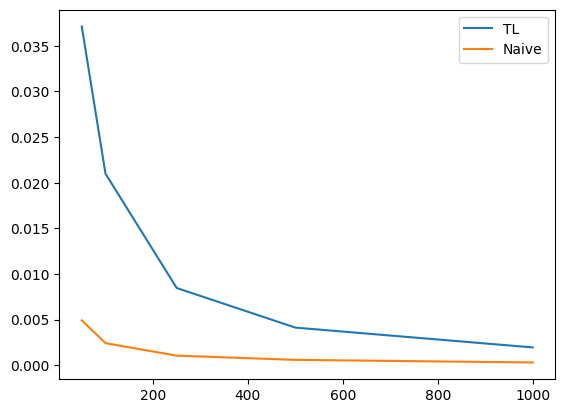

In [81]:
sizes = [50, 100, 250, 500, 1000]
tl = []
naive = []

for i in range(len(sizes)):
    res = parity_sim(
    n = sizes[i],
    parity = 'prob'
    )
    tl.append(res[1])
    naive.append(res[3])

plt.plot(sizes, tl, label="TL")
plt.plot(sizes, naive, label="Naive")
plt.legend()

In [43]:
def coverage_sim_parity(
    ground_truth,
    parity = 'threshold',
    product=True, 
    n_sim = 100, 
    n_samples = 100,
    proportion = 0.5):
    
    rng = np.random.default_rng()

    cov = np.array(
    [[1,0,0,0,0],
    [0,1,0.5,0,0],
    [0,0.5,1,0,0],
    [0,0,0,1,-0.5],
    [0,0,0,-0.5,1]])

    n_samples = n_samples // 2 # splitting samples; half for train, half for test
    estimates = np.zeros(n_sim)
    upper = np.zeros(n_sim)
    lower = np.zeros(n_sim)
    std = np.zeros(n_sim)
    for i in range(n_sim):
        x = rng.multivariate_normal(mean=np.zeros(5), cov=cov, size=(2*n_samples,))
        g = (rng.uniform(size = (2*n_samples,)) > proportion).astype(np.int8)
        xg = x
        xg[:,1] = xg[:,1] + 0.5*g
        xg[:,4] = xg[:,4] - 0.5*g

        if product:
            x14 = (xg[:,1] * xg[:,4]).reshape((len(xg),1))
            x23 = (xg[:,2] * xg[:,3]).reshape((len(xg),1))
            coef = np.array([-2, 3, -4, 3, -1, 2, 1])
            xg_input = np.hstack((xg, x14, x23))

        else:
            coef = np.array([-2, 3, -4, 3, -1])
            xg_input = xg
        
        y = (1/(1+np.exp(-xg_input@coef)) > 0.5).astype(np.int8)

        xgtrain = xg[:n_samples,:]
        gtrain = g[:n_samples]
        ytrain = y[:n_samples]
        xgtest = xg[n_samples:,:]
        gtest = g[n_samples:]
        ytest = y[n_samples:]

        model = LogisticRegression().fit(xgtrain,ytrain)

        if parity == 'threshold':
            phi0 = -1/np.mean(gtest==0) * model.predict(xgtest[np.where(gtest==0)[0],:])
            phi1 = 1/np.mean(gtest==1) * model.predict(xgtest[np.where(gtest==1)[0],:])
            phi = np.hstack([phi0, phi1])
            est = np.mean(phi)
            estimates[i] = est
            eif = phi - np.mean(phi)

        if parity == 'prob':
            propensity = LogisticRegression().fit(xgtrain,gtrain)
            m_probs = propensity.predict_proba(xgtest)
            f_probs = model.predict_proba(xgtest)[:,1]
            phi0 = -1/(np.mean(gtest==0)) * (m_probs[:,0]*((ytest==1) -f_probs) + (gtest==0)*f_probs)
            phi1 = 1/(np.mean(gtest==1)) * (m_probs[:,1]*((ytest==1) -f_probs) + (gtest==1)*f_probs)
            phi = phi0 + phi1
            est = np.mean(phi)
            estimates[i] = est
            eif = phi - (np.mean(phi1) + np.mean(phi0))

        std[i] = np.sqrt(np.var(eif)/n_samples)
        upper[i] = est + 1.96*np.sqrt(np.var(eif)/n_samples)
        lower[i] = est - 1.96*np.sqrt(np.var(eif)/n_samples)

    return ground_truth, estimates, std, upper, lower

In [47]:
def many_sim(
    sample_sizes,
    parity,
    ground_truth,
    n_sim,
    product=True):
    
    coverage = []
    reject_rate = []
    avg_est = []
    for size in sample_sizes:
        res = coverage_sim_parity(
            ground_truth=ground_truth,
            n_sim = n_sim,
            n_samples = size,
            parity=parity,
            product=product
        )
        upper = res[3]
        lower = res[4]
        truth = res[0]
        coverage.append(np.mean((upper >= truth)*(lower <= truth)))
        avg_est.append(np.mean(res[1]))
        reject_rate.append(np.mean(lower > 0))
    return coverage, avg_est, reject_rate


In [10]:
#sample_sizes = [10, 25, 50, 100]
sample_sizes = np.round(np.power(10, np.arange(1.5, 4, 0.01))).astype(np.int64)
coverage = []
avg_est = []
for size in sample_sizes:
    res = coverage_sim_parity(
        ground_truth=threshold_truth,
        n_sim = 100,
        n_samples = size
    )
    upper = res[3]
    lower = res[4]
    truth = res[0]
    coverage.append(np.mean((upper >= truth)*(lower <= truth)))
    avg_est.append(np.mean(res[1]))

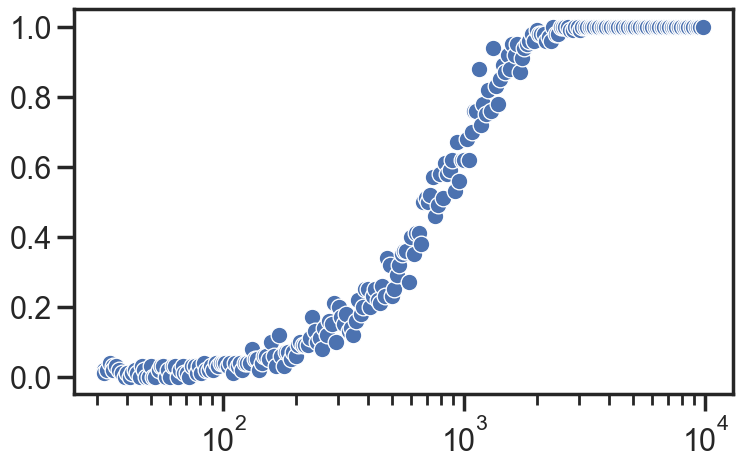

In [61]:
sample_sizes = np.round(np.power(10, np.arange(1.5, 4, 0.01))).astype(np.int64)
coverage, avg_est, reject_rate = many_sim(
    parity='threshold',
    ground_truth = threshold_truth,
    sample_sizes=sample_sizes,
    n_sim = 100
)
sns.set_theme(style='ticks')
sns.set_context('poster')
sns.scatterplot(x = sample_sizes, y = reject_rate)
plt.xscale('log')


Text(0, 0.5, 'Estimate')

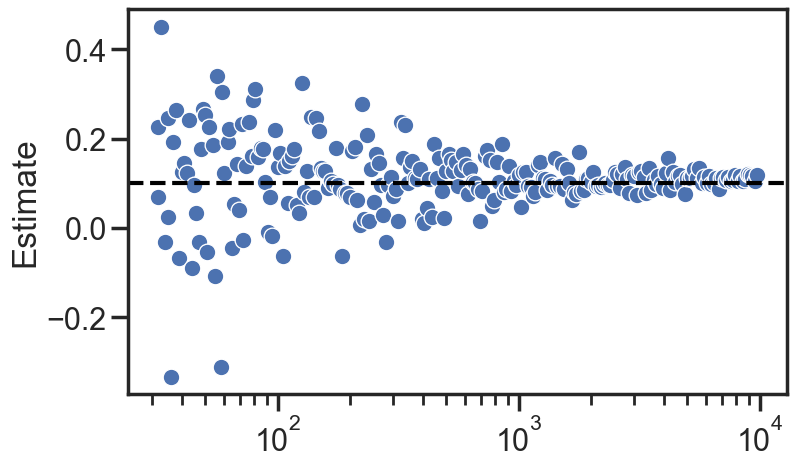

In [55]:
sample_sizes = np.round(np.power(10, np.arange(1.5, 4, 0.01))).astype(np.int64)
coverage = []
avg_est = []
for size in sample_sizes:
    res = coverage_sim_parity(
        ground_truth=threshold_truth,
        n_sim = 1,
        n_samples = size
    )
    upper = res[3]
    lower = res[4]
    truth = res[0]
    coverage.append(np.mean((upper >= truth)*(lower <= truth)))
    avg_est.append(np.mean(res[1]))
df = pd.DataFrame({
    'sample_sizes': sample_sizes,
    'estimate' : avg_est})

sns.set(rc={'figure.figsize':(8, 5)})
sns.set_theme(style='ticks')
sns.set_context('poster')
sns.scatterplot(data= df, x = 'sample_sizes', y = 'estimate')
plt.xscale('log')
plt.axhline(threshold_truth, color='black', linestyle='--')
plt.xlabel("")
plt.ylabel("Estimate")

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

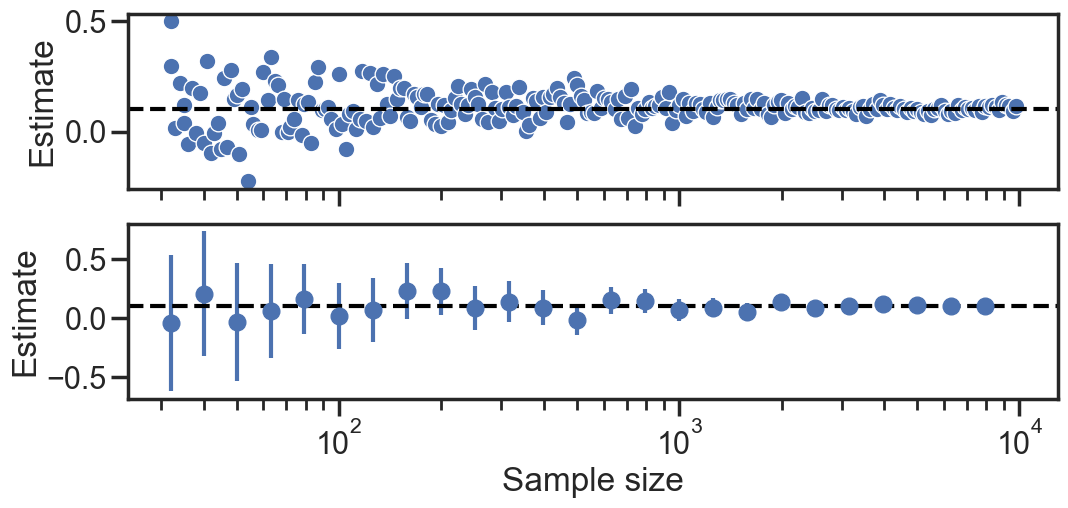

In [99]:
sample_sizes = np.round(np.power(10, np.arange(1.5, 4, 0.01))).astype(np.int64)
ci_samples = np.round(np.power(10, np.arange(1.5, 4, 0.1))).astype(np.int64)
coverage = []
avg_est = []
ci_est = []
std = []
for size in ci_samples:
    res = coverage_sim_parity(
        ground_truth=threshold_truth,
        n_sim = 1,
        n_samples = size
    )
    upper = res[3]
    lower = res[4]
    truth = res[0]
    # coverage.append(np.mean((upper >= truth)*(lower <= truth)))
    ci_est.append(np.mean(res[1]))
    std.append(res[2][0])
for size in sample_sizes:
    res = coverage_sim_parity(
        ground_truth=threshold_truth,
        n_sim = 1,
        n_samples = size
    )
    upper = res[3]
    lower = res[4]
    truth = res[0]
    coverage.append(np.mean((upper >= truth)*(lower <= truth)))
    avg_est.append(np.mean(res[1]))
df = pd.DataFrame({
    'sample_sizes': sample_sizes,
    'estimate' : avg_est})

fig, axes = plt.subplots(2)
fig.set_figwidth(12)
fig.set_figheight(5)
#fig.tight_layout()
# sns.set(rc={'figure.figsize':(8, 5)})
sns.set_theme(style='ticks')
sns.set_context('poster')
sns.scatterplot(data= df, x = 'sample_sizes', y = 'estimate', ax=axes[0])
axes[0].set_xscale('log')
axes[0].axhline(threshold_truth, color='black', linestyle='--')
axes[0].set_xlabel("")
axes[0].set_ylabel("Estimate")

sns.set_theme(style='ticks')
sns.set_context('poster')
#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)
axes[1].errorbar(ci_samples, ci_est, yerr=1.96*np.array(std), fmt='o')
axes[1].set_xscale('log')
axes[1].axhline(threshold_truth, color='black', linestyle='--')
plt.xlabel("Sample size")
plt.ylabel("Estimate")
axes[1].sharex(axes[0])
plt.setp(axes[0].get_xticklabels(), visible=False)

<AxesSubplot:>

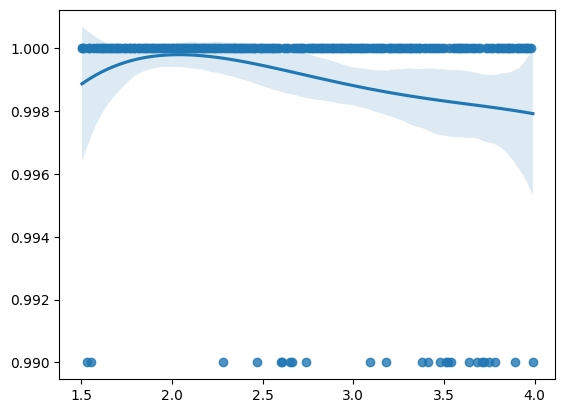

In [14]:
sample_sizes = np.round(np.power(10, np.arange(1.5, 4, 0.01))).astype(np.int64)
coverage, avg_est = many_sim(
    parity='prob',
    ground_truth = prob_truth,
    sample_sizes=sample_sizes,
    n_sim = 100
)
sns.regplot(x = np.log10(sample_sizes), y = coverage, order=4)

<AxesSubplot:>

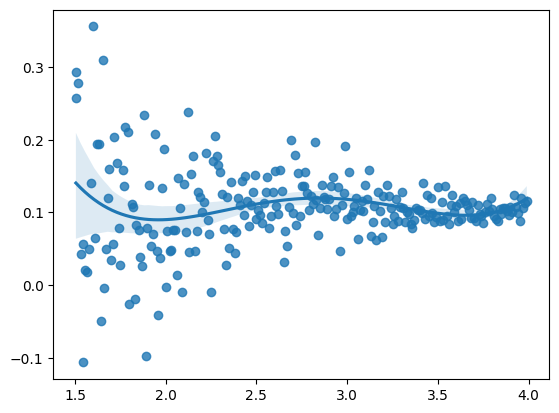

In [15]:
sample_sizes = np.round(np.power(10, np.arange(1.5, 4, 0.01))).astype(np.int64)
coverage = []
avg_est = []
for size in sample_sizes:
    res = coverage_sim_parity(
        ground_truth=prob_truth,
        n_sim=1,
        n_samples = size,
        parity = 'prob'
    )
    upper = res[3]
    lower = res[4]
    truth = res[0]
    coverage.append(np.mean((upper >= truth)*(lower <= truth)))
    avg_est.append(np.mean(res[1]))

sns.regplot(x = np.log10(sample_sizes), y = avg_est, order=4)

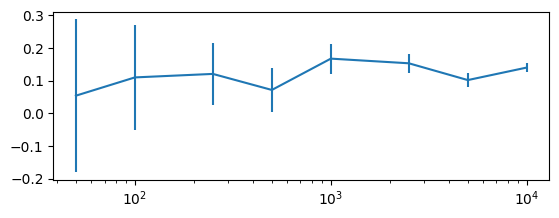

In [86]:
sample_sizes = [50, 100, 250, 500, 1000, 2500, 5000, 10000]
std = []
est = []
for size in sample_sizes:
    res = coverage_sim_parity(
        ground_truth=threshold_truth,
        n_sim = 1,
        n_samples=size
    )
    est.append(res[1][0])
    std.append(res[2][0])

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.errorbar(sample_sizes, est, yerr=std)
ax.set_xscale('log')